In [0]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Data Description:**

> The Street View House Numbers (SVHN) Dataset 
SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data formatting but comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images. 



**Objective:**

The objective of the project is to learn how to implement a simple image classification pipeline based on a deep neural network. The goals of this project are as follows:  
 
**Steps and tasks:**

**Import Necessary Libraries**

In [3]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.2.0'

In [4]:
import h5py
from keras.utils import np_utils 
import numpy as np

Using TensorFlow backend.


In [0]:
# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

**1. Load Dataset**

In [0]:

#Open the file as readonly/content/drive/My Drive/SVHN_single_grey1.h5
h5f = h5py.File('/content/drive/My Drive/SVHN_single_grey1.h5','r')

In [0]:
# Load the training, test and validation test
X_train= h5f['X_train'][:]
y_train1= h5f['y_train'][:]
X_test= h5f['X_test'][:]
y_test1= h5f['y_test'][:]
X_val= h5f['X_val'][:]
y_val1= h5f['y_val'][:]

**2. Understand the basic Image Classification pipeline and the data-driven approach (train/predict stages)**

**3. Data fetching and understand the train/val/test splits.** 

**Print shape of the data**

In [8]:
print(X_train.shape)
print(y_train1.shape)
print(X_test.shape)
print(y_test1.shape)
print(X_val.shape)
print(y_val1.shape)


(42000, 32, 32)
(42000,)
(18000, 32, 32)
(18000,)
(60000, 32, 32)
(60000,)


**Reshape features**

*   reshape() method gives a new shape to an array without changing its data
*   we have used 1024 as it is 32 X 32 dimensions



In [9]:
X_train = X_train.reshape(42000,1024)
print(X_train.shape)
X_test = X_test.reshape(18000,1024)
print(X_test.shape)

(42000, 1024)
(18000, 1024)


**Normalize features**
*   Normalize features from 0-255 to 0-1

In [10]:
X_train=X_train/255.0
X_test = X_test/255.0
print(X_train.shape)
print(X_test.shape)

(42000, 1024)
(18000, 1024)


In [11]:
print(X_train.max())
print(X_train.min())

0.9999
0.0


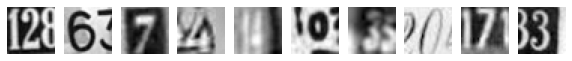

label for each of the above image:[2 6 7 4 4 0 3 0 7 3]


In [0]:
#visualizing the first 10 images in the dataset and their labels
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,1))
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.imshow(X_train[i].reshape(32,32),cmap='gray')
  plt.axis('off')
plt.show()
print('label for each of the above image:%s' %(y_train1[0:10]))

**4.Implement and apply a deep neural network classifier including (feedforward neural network, RELU, activations)**

**a. Creating a model
Keras model object can be created from Scratch**

In [0]:
import numpy as np 

class Linear():
    def __init__(self, in_size, out_size):
        self.W = np.random.randn(in_size, out_size) * 0.01
        self.b = np.zeros((1, out_size))
        self.params = [self.W, self.b]
        self.gradW = None
        self.gradB = None
        self.gradInput = None        

    def forward(self, X):
        self.X = X
        self.output = np.dot(X, self.W) + self.b
        return self.output

    def backward(self, nextgrad):
        self.gradW = np.dot(self.X.T, nextgrad)
        self.gradB = np.sum(nextgrad, axis=0)
        self.gradInput = np.dot(nextgrad, self.W.T)
        return self.gradInput, [self.gradW, self.gradB]

In [0]:
class ReLU():
    def __init__(self):
        self.params = []
        self.gradInput = None

    def forward(self, X):
        self.output = np.maximum(X, 0)
        return self.output

    def backward(self, nextgrad):
        self.gradInput = nextgrad.copy()
        self.gradInput[self.output <=0] = 0
        return self.gradInput, []

In [0]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

In [0]:
class CrossEntropy:
    def forward(self, X, y):
        self.m = y.shape[0]
        self.p = softmax(X)
        cross_entropy = -np.log(self.p[range(self.m), y])
        loss = cross_entropy[0] / self.m
        return loss
    
    def backward(self, X, y):
        y_idx = y.argmax()        
        grad = softmax(X)
        grad[range(self.m), y] -= 1
        grad /= self.m
        return grad

In [0]:



class NN():
    def __init__(self, lossfunc=CrossEntropy()):
        self.params = []
        self.layers = []
        self.loss_func = lossfunc
        self.grads = []
        
    def add_layer(self, layer):
        self.layers.append(layer)
        self.params.append(layer.params)

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward(self, nextgrad):
        self.clear_grad_param()
        for layer in reversed(self.layers):
            nextgrad, grad = layer.backward(nextgrad)
            self.grads.append(grad)
        return self.grads
    
    def train_step(self, X, y):
        out = self.forward(X)
        loss = self.loss_func.forward(out,y)
        nextgrad = self.loss_func.backward(out,y)
        grads = self.backward(nextgrad)
        return loss, grads
    
    def predict(self, X):
        X = self.forward(X)
        return np.argmax(X, axis=1)
    
    def predict_scores(self, X):
        X = self.forward(X)
        return X
    
    def clear_grad_param(self):
        self.grads = []

In [0]:
def update_params(velocity, params, grads, learning_rate=0.01, mu=0.9):
    for v, p, g, in zip(velocity, params, reversed(grads)):
        for i in range(len(g)):
            v[i] = mu * v[i] + learning_rate * g[i]
            p[i] -= v[i]

In [0]:
# get minibatches
def minibatch(X, y, minibatch_size):
    n = X.shape[0]
    minibatches = []
    permutation = np.random.permutation(X.shape[0])
    X = X[permutation]
    y = y[permutation]
    
    for i in range(0, n , minibatch_size):
        X_batch = X[i:i + minibatch_size, :]
        y_batch = y[i:i + minibatch_size, ]
        minibatches.append((X_batch, y_batch))
        
    return minibatches

In [0]:
def train(net, X_train, y_train, minibatch_size, epoch, learning_rate, mu=0.9, X_val=None, y_val=None):
    val_loss_epoch = []
    minibatches = minibatch(X_train, y_train, minibatch_size)
    minibatches_val = minibatch(X_val, y_val, minibatch_size)

    
    for i in range(epoch):
        loss_batch = []
        val_loss_batch = []
        velocity = []
        for param_layer in net.params:
            p = [np.zeros_like(param) for param in list(param_layer)]
            velocity.append(p)
            
        # iterate over mini batches
        for X_mini, y_mini in minibatches:
            loss, grads = net.train_step(X_mini, y_mini)
            loss_batch.append(loss)
            update_params(velocity, net.params, grads, learning_rate=learning_rate, mu=mu)

        for X_mini_val, y_mini_val in minibatches_val:
            val_loss, _ = net.train_step(X_mini, y_mini)
            val_loss_batch.append(val_loss)
        
        # accuracy of model at end of epoch after all mini batch updates
        m_train = X_train.shape[0]
        m_val = X_val.shape[0]
        y_train_pred = np.array([], dtype="int64")
        y_val_pred = np.array([], dtype="int64")
        y_train1 = []
        y_vall = []
        for i in range(0, m_train, minibatch_size):
            X_tr = X_train[i:i + minibatch_size, : ]
            y_tr = y_train[i:i + minibatch_size,]
            y_train1 = np.append(y_train1, y_tr)
            y_train_pred = np.append(y_train_pred, net.predict(X_tr))

        for i in range(0, m_val, minibatch_size):
            X_va = X_val[i:i + minibatch_size, : ]
            y_va = y_val[i:i + minibatch_size,]
            y_vall = np.append(y_vall, y_va)
            y_val_pred = np.append(y_val_pred, net.predict(X_va))
            
        train_acc = check_accuracy(y_train1, y_train_pred)
        val_acc = check_accuracy(y_vall, y_val_pred)

        mean_train_loss = sum(loss_batch) / float(len(loss_batch))
        mean_val_loss = sum(val_loss_batch) / float(len(val_loss_batch))
        
        val_loss_epoch.append(mean_val_loss)
        print("Loss = {0} | Training Accuracy = {1} | Val Loss = {2} | Val Accuracy = {3}".format(mean_train_loss, train_acc, mean_val_loss, val_acc))
    return net

In [0]:
def check_accuracy(y_true, y_pred):
    return np.mean(y_pred == y_true)

In [0]:



from random import shuffle

## input size
input_dim = X_train.shape[1]

## hyperparameters
iterations = 10
learning_rate = 0.1
hidden_nodes = 32
output_nodes = 10

## define neural net
nn = NN()
nn.add_layer(Linear(input_dim, hidden_nodes))
nn.add_layer(ReLU())
nn.add_layer(Linear(hidden_nodes, output_nodes))

nn = train(nn, X_train , y_train1, minibatch_size=200, epoch=100, \
           learning_rate=learning_rate, X_val=X_test, y_val=y_test1)

Loss = 0.01148666903400712 | Training Accuracy = 0.09866666666666667 | Val Loss = 0.011479538557069853 | Val Accuracy = 0.09822222222222222
Loss = 0.011154213101038911 | Training Accuracy = 0.1260238095238095 | Val Loss = 0.012139282878346995 | Val Accuracy = 0.129
Loss = 0.011048650384625651 | Training Accuracy = 0.13116666666666665 | Val Loss = 0.012319981857825978 | Val Accuracy = 0.12694444444444444
Loss = 0.010602341995352335 | Training Accuracy = 0.16352380952380952 | Val Loss = 0.011509493435069046 | Val Accuracy = 0.1615
Loss = 0.010098871986259587 | Training Accuracy = 0.16897619047619047 | Val Loss = 0.011454795518487522 | Val Accuracy = 0.16983333333333334
Loss = 0.010076455446187732 | Training Accuracy = 0.19064285714285714 | Val Loss = 0.011291108355264057 | Val Accuracy = 0.18544444444444444
Loss = 0.01004755272962874 | Training Accuracy = 0.19230952380952382 | Val Loss = 0.011296408072559612 | Val Accuracy = 0.19066666666666668
Loss = 0.01025994995060695 | Training Accur

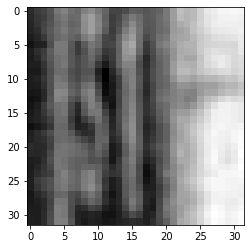

In [0]:
plt.imshow(X_test[0].reshape(32,32), cmap='gray')

In [0]:
# Predict Scores for each class
prediction = nn.predict_scores(X_test[0])[0]

In [0]:
print ("Scores")
print (prediction)

Scores
[ 0.12233832  0.07712824  0.0026162  -0.10811127 -0.01489851 -0.02053064
 -0.06009443 -0.01255023  0.02048794 -0.00638563]


In [0]:
np.argmax(prediction)

0

In [0]:
predict_class = nn.predict(X_test[0])[0]
predict_class

0

In [0]:
# Original class
y_test1[0]

1

**As you can see this model did not do well as the accuraccy is 0.25 and the prediction is not accurate**

**b. Create Model 2 with Sequential with Hyperparameter Tuning**


**One-hot encode the class vector**
* convert class vectors (integers) to binary class matrix
* convert X_train and X_val
* number of classes: 10

In [12]:
print(y_train1[10])
y_train1 = tensorflow.keras.utils.to_categorical(y_train1, num_classes=10)
y_test1 = tensorflow.keras.utils.to_categorical(y_test1, num_classes=10)
print(y_train1[10])

1
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers, optimizers

#def train_and_test_loop(iterations, lr, Lambda, verb=True):

    ## hyperparameters
iterations = 10
learning_rate = 0.00001
hidden_nodes = 256
output_nodes = 10
        
model = Sequential()
model.add(Dense(hidden_nodes, input_shape=(1024,), activation='relu'))
model.add(Dense(hidden_nodes, activation='relu'))
model.add(Dense(output_nodes, activation='softmax', kernel_regularizer=regularizers.l2(0)))
   
sgd = optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=0.9)
   # Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    # Fit the model
#model.fit(X_train, y_train, epochs=iterations, batch_size=1000, verbose= 1)

In [15]:
model.fit(X_train, y_train1, epochs=iterations, batch_size=1000, verbose= 1)

Epoch 1/10
42/42 [==============================] - 1s 32ms/step - loss: 2.3530 - accuracy: 0.0999
Epoch 2/10
42/42 [==============================] - 1s 31ms/step - loss: 2.3488 - accuracy: 0.1000
Epoch 3/10
42/42 [==============================] - 1s 31ms/step - loss: 2.3449 - accuracy: 0.1000
Epoch 4/10
42/42 [==============================] - 1s 31ms/step - loss: 2.3415 - accuracy: 0.1001
Epoch 5/10
42/42 [==============================] - 1s 31ms/step - loss: 2.3384 - accuracy: 0.1003
Epoch 6/10
42/42 [==============================] - 1s 31ms/step - loss: 2.3356 - accuracy: 0.1005
Epoch 7/10
42/42 [==============================] - 1s 31ms/step - loss: 2.3331 - accuracy: 0.1008
Epoch 8/10
42/42 [==============================] - 1s 31ms/step - loss: 2.3309 - accuracy: 0.1010
Epoch 9/10
42/42 [==============================] - 1s 32ms/step - loss: 2.3289 - accuracy: 0.1016
Epoch 10/10
42/42 [==============================] - 1s 31ms/step - loss: 2.3271 - accuracy: 0.1016



> **Creating model 2**

* Same model as above
* Instead of accuracy at each epoch below code gives the consolidate accuracy
* Notice: The model.evaluate line at the last is the only difference from model 1

In [0]:
def train_and_test_loop1(iterations, lr, Lambda, verb=True):

    ## hyperparameters
    iterations = iterations
    learning_rate = lr
    hidden_nodes = 256
    output_nodes = 10

    model = Sequential()
    model.add(Dense(hidden_nodes, input_shape=(1024,), activation='relu'))
    model.add(Dense(hidden_nodes, activation='relu'))
    model.add(Dense(output_nodes, activation='softmax', kernel_regularizer=regularizers.l2(Lambda)))
    
    sgd = optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=0.9)
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    # Fit the model
    model.fit(X_train, y_train1, epochs=iterations, batch_size=1000, verbose= 1)
    score = model.evaluate(X_train, y_train1, verbose=0)
    
    return score

**Next steps**
* Double Check that the loss is reasonable
* Disable the regularization (Lambda = 0)

In [17]:
lr = 0.00001
Lambda = 0
train_and_test_loop1(1, lr, Lambda)

42/42 [==============================] - 1s 31ms/step - loss: 2.3193 - accuracy: 0.1001


[2.3184993267059326, 0.10019047558307648]

**Now, lets crank up the Lambda(Regularization)and check what it does to our loss function.**

In [0]:
X_train_subset = X_train[0:20]

In [0]:
y_train_subset = y_train1[0:20]

In [0]:
X_train = X_train_subset
y_train1 = y_train_subset

In [21]:
X_train.shape

(20, 1024)

In [22]:
y_train1.shape

(20, 10)

In the code below:
* Take the first 20 examples from SVHN
* turn off regularization(reg=0.0)
* use simple vanilla 'sgd'
* Lets try and run for 500 iterations as the data set is very small

In [23]:
lr = 0.001
Lambda = 0
train_and_test_loop1(500, lr, Lambda)

Epoch 1/500
1/1 [==============================] - 0s 2ms/step - loss: 2.5094 - accuracy: 0.0000e+00
Epoch 2/500
1/1 [==============================] - 0s 1ms/step - loss: 2.4852 - accuracy: 0.0000e+00
Epoch 3/500
1/1 [==============================] - 0s 952us/step - loss: 2.4417 - accuracy: 0.0000e+00
Epoch 4/500
1/1 [==============================] - 0s 2ms/step - loss: 2.3846 - accuracy: 0.0000e+00
Epoch 5/500
1/1 [==============================] - 0s 1ms/step - loss: 2.3196 - accuracy: 0.1500
Epoch 6/500
1/1 [==============================] - 0s 3ms/step - loss: 2.2508 - accuracy: 0.2500
Epoch 7/500
1/1 [==============================] - 0s 1ms/step - loss: 2.1843 - accuracy: 0.2500
Epoch 8/500
1/1 [==============================] - 0s 883us/step - loss: 2.1229 - accuracy: 0.2500
Epoch 9/500
1/1 [==============================] - 0s 1ms/step - loss: 2.0689 - accuracy: 0.2500
Epoch 10/500
1/1 [==============================] - 0s 2ms/step - loss: 2.0228 - accuracy: 0.2500
Epoch 11/

[0.14368698000907898, 1.0]

**Very small loss, train accuracy going to 100, nice! We are successful in overfitting. The model architecture looks fine. Lets go for fine tuning it.**

**Loading the original dataset again**

**Import dataset**
* This dataset can be imported
* High level API Keras has some datasets available
* h5py.FIle() returns two tuples (x_train, y_train1), (x_test, y_test1):
 * x_train, x_test: uint8 array of grayscale image data with shape (num_samples, 32, 32)
 * y_test1, y_test1: uint8 array of digit labels (integers in range 0-9) with shape (num_samples,).

In [0]:
#Open the file as readonly/content/drive/My Drive/SVHN_single_grey1.h5
h5f = h5py.File('/content/drive/My Drive/SVHN_single_grey1.h5','r')

In [0]:
# Load the training, test / validation test
X_train= h5f['X_train'][:]
y_train1= h5f['y_train'][:]
X_test= h5f['X_test'][:]
y_test1= h5f['y_test'][:]

**Reshape Features**

In [26]:
X_train = X_train.reshape(42000, 1024)
print(X_train.shape)
X_test = X_test.reshape(18000, 1024)
print(X_test.shape)

(42000, 1024)
(18000, 1024)



**Normalize features**
* Normalize features from 0-255 to 0-1

In [0]:
X_train = X_train / 255.0
X_test = X_test / 255.0

**One Hot Encoder**
* convert class vectors (integers) to binary class matrix
* convert X_train and X_val
* number of classes: 10

In [0]:
y_train1 = tensorflow.keras.utils.to_categorical(y_train1, num_classes=10)
y_test1 = tensorflow.keras.utils.to_categorical(y_test1, num_classes=10)


**Start with small regularization and find learning rate that makes the loss go down.**
* we start with Lambda(small regularization) = 1e-7
* we start with a small learning rate = 1e-7

In [29]:
lr = 1e-7
Lambda = 1e-7
train_and_test_loop1(20, lr, Lambda)

Epoch 1/20
42/42 [==============================] - 1s 31ms/step - loss: 2.3640 - accuracy: 0.0998
Epoch 2/20
42/42 [==============================] - 1s 31ms/step - loss: 2.3639 - accuracy: 0.0997
Epoch 3/20
42/42 [==============================] - 1s 31ms/step - loss: 2.3638 - accuracy: 0.0998
Epoch 4/20
42/42 [==============================] - 1s 32ms/step - loss: 2.3638 - accuracy: 0.0998
Epoch 5/20
42/42 [==============================] - 1s 31ms/step - loss: 2.3637 - accuracy: 0.0998
Epoch 6/20
42/42 [==============================] - 1s 31ms/step - loss: 2.3636 - accuracy: 0.0998
Epoch 7/20
42/42 [==============================] - 1s 31ms/step - loss: 2.3635 - accuracy: 0.0998
Epoch 8/20
42/42 [==============================] - 1s 32ms/step - loss: 2.3635 - accuracy: 0.0998
Epoch 9/20
42/42 [==============================] - 1s 32ms/step - loss: 2.3634 - accuracy: 0.0998
Epoch 10/20
42/42 [==============================] - 1s 31ms/step - loss: 2.3633 - accuracy: 0.0998
Epoch 11/

[2.362602710723877, 0.09971428662538528]


**Loss barely changing. Learning rate is probably too low.**

**Okay now lets try a (larger) learning rate 1e6. What could possibly go wrong?**
* Learning rate lr = 1e8
* Regularization lambda = 1e-7

In [30]:
lr = 1e8
Lambda = 1e-7
train_and_test_loop1(20, lr, Lambda)

Epoch 1/20
42/42 [==============================] - 1s 31ms/step - loss: nan - accuracy: 0.0994
Epoch 2/20
42/42 [==============================] - 1s 32ms/step - loss: nan - accuracy: 0.0997
Epoch 3/20
42/42 [==============================] - 1s 31ms/step - loss: nan - accuracy: 0.0997
Epoch 4/20
42/42 [==============================] - 1s 31ms/step - loss: nan - accuracy: 0.0997
Epoch 5/20
42/42 [==============================] - 1s 32ms/step - loss: nan - accuracy: 0.0997
Epoch 6/20
42/42 [==============================] - 1s 31ms/step - loss: nan - accuracy: 0.0997
Epoch 7/20
42/42 [==============================] - 1s 31ms/step - loss: nan - accuracy: 0.0997
Epoch 8/20
42/42 [==============================] - 1s 32ms/step - loss: nan - accuracy: 0.0997
Epoch 9/20
42/42 [==============================] - 1s 31ms/step - loss: nan - accuracy: 0.0997
Epoch 10/20
42/42 [==============================] - 1s 31ms/step - loss: nan - accuracy: 0.0997
Epoch 11/20
42/42 [====================

[nan, 0.09966666996479034]

**Loss exploding. Learning rate is too high.**
**Cost is very high. Always means high learning rate**

**Lets try to train now with a value of learning rate between 1e-7 and 1e8**
* learning rate = 1e4
* regularization remains the small, lambda = 1e-7

In [31]:
lr = 1e4
Lambda = 1e-7
train_and_test_loop1(20, lr, Lambda)

Epoch 1/20
42/42 [==============================] - 1s 31ms/step - loss: nan - accuracy: 0.0990
Epoch 2/20
42/42 [==============================] - 1s 31ms/step - loss: nan - accuracy: 0.0997
Epoch 3/20
42/42 [==============================] - 1s 32ms/step - loss: nan - accuracy: 0.0997
Epoch 4/20
42/42 [==============================] - 1s 31ms/step - loss: nan - accuracy: 0.0997
Epoch 5/20
42/42 [==============================] - 1s 31ms/step - loss: nan - accuracy: 0.0997
Epoch 6/20
42/42 [==============================] - 1s 31ms/step - loss: nan - accuracy: 0.0997
Epoch 7/20
42/42 [==============================] - 1s 31ms/step - loss: nan - accuracy: 0.0997
Epoch 8/20
42/42 [==============================] - 1s 31ms/step - loss: nan - accuracy: 0.0997
Epoch 9/20
42/42 [==============================] - 1s 31ms/step - loss: nan - accuracy: 0.0997
Epoch 10/20
42/42 [==============================] - 1s 31ms/step - loss: nan - accuracy: 0.0997
Epoch 11/20
42/42 [====================

[nan, 0.09966666996479034]

**Still too high learning rate. Loss is not decreasing. The rough range of learning rate we should be cross validating is somewhere between [1e3 to 1e-7]**


**Hyperparameter Optimization**


In [32]:
import math
for k in range(1,10):
    lr = math.pow(10, np.random.uniform(-7.0, 3.0))
    Lambda = math.pow(10, np.random.uniform(-7,-2))
    best_acc = train_and_test_loop1(100, lr, Lambda, False)
    print("Try {0}/{1}: Best_val_acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 100, best_acc, lr, Lambda))

Epoch 1/100
42/42 [==============================] - 1s 31ms/step - loss: 2.3074 - accuracy: 0.1059
Epoch 2/100
42/42 [==============================] - 1s 31ms/step - loss: 2.2933 - accuracy: 0.1245
Epoch 3/100
42/42 [==============================] - 1s 31ms/step - loss: 2.2866 - accuracy: 0.1408
Epoch 4/100
42/42 [==============================] - 1s 31ms/step - loss: 2.2802 - accuracy: 0.1602
Epoch 5/100
42/42 [==============================] - 1s 31ms/step - loss: 2.2739 - accuracy: 0.1728
Epoch 6/100
42/42 [==============================] - 1s 31ms/step - loss: 2.2676 - accuracy: 0.1917
Epoch 7/100
42/42 [==============================] - 1s 31ms/step - loss: 2.2604 - accuracy: 0.2132
Epoch 8/100
42/42 [==============================] - 1s 31ms/step - loss: 2.2527 - accuracy: 0.2323
Epoch 9/100
42/42 [==============================] - 1s 31ms/step - loss: 2.2445 - accuracy: 0.2427
Epoch 10/100
42/42 [==============================] - 1s 32ms/step - loss: 2.2357 - accuracy: 0.2629


**As you can see from above, Case 1, 7 and 8 yields good accuracy. It is better to focus on those values for learning rate and Lambda**

**Now run finer search**


In [33]:
import math
for k in range(1,5):
    lr = math.pow(10, np.random.uniform(-4.0, -2.0))
    Lambda = math.pow(10, np.random.uniform(-5,-2))
    best_acc = train_and_test_loop1(100, lr, Lambda, False)
    print("Try {0}/{1}: Best_val_acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 100, best_acc, lr, Lambda))

Epoch 1/100
42/42 [==============================] - 1s 31ms/step - loss: 2.4458 - accuracy: 0.0977
Epoch 2/100
42/42 [==============================] - 1s 32ms/step - loss: 2.4207 - accuracy: 0.1136
Epoch 3/100
42/42 [==============================] - 1s 32ms/step - loss: 2.4159 - accuracy: 0.1260
Epoch 4/100
42/42 [==============================] - 1s 32ms/step - loss: 2.4119 - accuracy: 0.1357
Epoch 5/100
42/42 [==============================] - 1s 31ms/step - loss: 2.4084 - accuracy: 0.1401
Epoch 6/100
42/42 [==============================] - 1s 31ms/step - loss: 2.4052 - accuracy: 0.1506
Epoch 7/100
42/42 [==============================] - 1s 31ms/step - loss: 2.4024 - accuracy: 0.1566
Epoch 8/100
42/42 [==============================] - 1s 31ms/step - loss: 2.4000 - accuracy: 0.1612
Epoch 9/100
42/42 [==============================] - 1s 32ms/step - loss: 2.3976 - accuracy: 0.1658
Epoch 10/100
42/42 [==============================] - 1s 32ms/step - loss: 2.3953 - accuracy: 0.1704

Running deep with lr=0.007 and Lambda=1e-5

In [34]:
lr = 7e-3
Lambda = 1e-5
train_and_test_loop1(100, lr, Lambda)

Epoch 1/100
42/42 [==============================] - 1s 31ms/step - loss: 2.3025 - accuracy: 0.1238
Epoch 2/100
42/42 [==============================] - 1s 31ms/step - loss: 2.2796 - accuracy: 0.1705
Epoch 3/100
42/42 [==============================] - 1s 31ms/step - loss: 2.2584 - accuracy: 0.2173
Epoch 4/100
42/42 [==============================] - 1s 31ms/step - loss: 2.2289 - accuracy: 0.2770
Epoch 5/100
42/42 [==============================] - 1s 32ms/step - loss: 2.1905 - accuracy: 0.3229
Epoch 6/100
42/42 [==============================] - 1s 31ms/step - loss: 2.1372 - accuracy: 0.3697
Epoch 7/100
42/42 [==============================] - 1s 32ms/step - loss: 2.0691 - accuracy: 0.3978
Epoch 8/100
42/42 [==============================] - 1s 31ms/step - loss: 1.9831 - accuracy: 0.4262
Epoch 9/100
42/42 [==============================] - 1s 31ms/step - loss: 1.8831 - accuracy: 0.4592
Epoch 10/100
42/42 [==============================] - 1s 31ms/step - loss: 1.7825 - accuracy: 0.4870

[0.5327198505401611, 0.8442857265472412]

Hence, we can see that using the learning rate around 
0.0075 and Lambda 1e-5 gives us a better accuracy

**5. Implement batch normalization for training the neural network**

>   Create Sequential with Drop and Batch Normalization along with the hyperparameters that we recieved after tuning.



In [0]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers


In [0]:
#Open the file as readonly/content/drive/My Drive/SVHN_single_grey1.h5
h5f = h5py.File('/content/drive/My Drive/SVHN_single_grey1.h5','r')

In [0]:
# Load the training, test and validation test
X_train= h5f['X_train'][:]
y_train1= h5f['y_train'][:]
X_test= h5f['X_test'][:]
y_test1= h5f['y_test'][:]

In [38]:
X_train.shape

(42000, 32, 32)

In [39]:
X_test.shape

(18000, 32, 32)

In [40]:
X_train = X_train.reshape(42000,1024)
print(X_train.shape)
X_test = X_test.reshape(18000,1024)
print(X_test.shape)

(42000, 1024)
(18000, 1024)


In [41]:
X_train=X_train/255.0
X_test = X_test/255.0
print(X_train.shape)
print(X_test.shape)

(42000, 1024)
(18000, 1024)


In [42]:
print(y_train1[10])
y_train1 = tensorflow.keras.utils.to_categorical(y_train1, num_classes=10)
y_test1 = tensorflow.keras.utils.to_categorical(y_test1, num_classes=10)
print(y_train1[10])

1
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [0]:

## hyperparameters
iterations = 10
Lambda=1e-5
hidden_nodes = 722
output_nodes = 10


In [0]:

model2 = Sequential()
model2.add(Dense(hidden_nodes, input_shape = (1024,), activation = 'relu'))
model2.add(Dense(hidden_nodes, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(10 , activation = 'softmax',kernel_regularizer=regularizers.l2(Lambda)))
sgd = optimizers.Adam(lr = 0.0075)
model2.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics=['accuracy'])


In [54]:
model2.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 722)               740050    
_________________________________________________________________
dense_68 (Dense)             (None, 722)               522006    
_________________________________________________________________
batch_normalization_2 (Batch (None, 722)               2888      
_________________________________________________________________
dropout_2 (Dropout)          (None, 722)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 10)                7230      
Total params: 1,272,174
Trainable params: 1,270,730
Non-trainable params: 1,444
_________________________________________________________________


In [55]:
model2.fit(X_train, y_train1,validation_data=(X_test,y_test1),epochs=100,batch_size=1000)

Epoch 1/100
42/42 [==============================] - 6s 152ms/step - loss: 2.5943 - accuracy: 0.1077 - val_loss: 3.3048 - val_accuracy: 0.0983
Epoch 2/100
42/42 [==============================] - 6s 151ms/step - loss: 2.3193 - accuracy: 0.1285 - val_loss: 2.5239 - val_accuracy: 0.0982
Epoch 3/100
42/42 [==============================] - 6s 150ms/step - loss: 2.2146 - accuracy: 0.1726 - val_loss: 2.8139 - val_accuracy: 0.1056
Epoch 4/100
42/42 [==============================] - 6s 149ms/step - loss: 2.0123 - accuracy: 0.2500 - val_loss: 2.4650 - val_accuracy: 0.1246
Epoch 5/100
42/42 [==============================] - 6s 149ms/step - loss: 1.8255 - accuracy: 0.3275 - val_loss: 2.1745 - val_accuracy: 0.2557
Epoch 6/100
42/42 [==============================] - 6s 150ms/step - loss: 1.6900 - accuracy: 0.3919 - val_loss: 1.8553 - val_accuracy: 0.3566
Epoch 7/100
42/42 [==============================] - 6s 149ms/step - loss: 1.5837 - accuracy: 0.4463 - val_loss: 1.7983 - val_accuracy: 0.3323

**6. Print the classification accuracy metrics**

In [56]:
score = model2.evaluate(X_train, y_train1, verbose=0)

[0.44582027196884155, 0.8563809394836426]


In [60]:
print("Accuracy of the model : {1} with loss {0}\n".format(score[0],score[1]))
#"Try {0}/{1}: Best_val_acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 100, best_acc, lr, Lambda)

Accuracy of the model : 0.8563809394836426 with loss 0.44582027196884155

